In [2]:
import pandas as pd

In [3]:
import torch

In [4]:
from transformers import BertModel,BertTokenizer

d:\anaconda3\envs\torch311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import numpy as np

In [6]:
from tqdm import tqdm

In [7]:
import os
import tarfile
from Bio import SeqIO
from tqdm import tqdm
import matplotlib.pyplot as plt

In [8]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


2.5.1+cu121
True
NVIDIA GeForce RTX 4060 Laptop GPU


In [ ]:
torch.cuda.is_available()
from huggingface_hub import login
login("")


In [ ]:
fasta_dir = "C:/Users/karti/Downloads/18S_fungal_sequences.fasta"
batch_size = 16
embedding_file = "dnabert_embeddings.npy"
id_file = "sequence_ids.csv"
preview_limit = 100 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
fasta_file = "C:/Users/karti/Downloads/18S_fungal_sequences.fasta"
sequences = []
for record in SeqIO.parse(fasta_file, "fasta"):
    sequences.append((record.id, str(record.seq)))
print(f"Total sequences loaded: {len(sequences)}")
print("First example:", sequences[0])

Using device: cuda
Total sequences loaded: 3692
First example: ('NG_065155.1', 'TATCTGGTTGATCCTGCCAGTAGTCATATGCTTGTCTCAAAGATTAAGCCATGCATGTCTAAGTATAAGCAATTTATACAGTGAAACTGCGAATGGCTCATTAAATCAGTTATCGTTTATTTGATAGTTCCTTTACTACATGGTATAACTGTGGTAATTCTAGAGCTAATACATGCTTAAAATCTCGACCTTTCGGAAGAGATGTATTTATTAGATAAAAAATCAACGTCTTCGGACTCCTTGATGATTCATAATAACTTTTCGAATCGCATGGCCTTGTGCTGGCGATGGTTCATTCAAATTTCTGCCCTATCAACTTTCGATGGTAGGATAGTGGCCTACCATGGTTTCAACGGGTAACGGGGAATAAGGGTTCGATTCCGGAGAGGGAGCCTGAGAAACGGCTACCACATCCAAGGAAGGCAGCAGGCGCGCAAATTACCCAATCCTGACACAGGGAGGTAGTGACAATAAATAACGATACAGGGCCCTTACGGGTCTTGTAATTGGAATGAGTACAATGTAAATACCTTAACGAGGAACAATTGGAGGGCAAGTCTGGTGCCAGCAGCCGCGGTAATTCCAGCTCCAATAGCGTATATTAAAGTTGTTGCAGTTAAAAAGCTCGTAGTTGAACTTTGGGCCTGGTCGGCCGGTCCGGATTTTTCCGCGTACTGGTTTTTCCGACCGGGCCTTTCCTTCTGGCTAGCCCTGGGTCCTTGTGGCCCTTGGTGAACCAGGACTTTTACTTTGAAAAAATTAGAGTGTTCAAAGCAGGCGTATTGCTCGAATATATTAGCATGGAATAATAGAATAGGACGTTTGGTTCTATTTTGTTGGTTTCTAGGACCATCGTAATGATTAATAGGGACGGTCGGGGGCATCAGTATTCAGTTGTCGAGGTGAAATTCTTGGATTTA

In [9]:
#model_path = r"D:/models/DNA_bert_6"
#tokenizer = BertTokenizer.from_pretrained(model_path, local_files_only=True)
#model = BertModel.from_pretrained(model_path, local_files_only=True)
#model.to(device)
#model.eval()

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch
model_name = "InstaDeepAI/nucleotide-transformer-v2-50m-multi-species"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForMaskedLM.from_pretrained(model_name, trust_remote_code=True, output_hidden_states=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
seq_id, seq = sequences[0]
inputs = tokenizer(seq, return_tensors="pt", padding=True, truncation=True)
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
    last_hidden = outputs.hidden_states[-1]   
    embedding = last_hidden.mean(dim=1).cpu() 
print(seq_id, embedding.shape)



NG_065155.1 torch.Size([1, 512])


In [ ]:
def seq_to_kmers(seq, k=6):
    seq = seq.upper()
    return [seq[i:i+k] for i in range(len(seq)-k+1)]

In [ ]:
if os.path.exists(embedding_file):
    all_embeddings = list(np.load(embedding_file, allow_pickle=True))
    sequence_ids_saved = pd.read_csv(id_file)['sequence_id'].tolist()
    total_saved = len(sequence_ids_saved)
    print(f"Resuming from previously saved {total_saved} sequences")
else:
    all_embeddings = []
    sequence_ids_saved = []
    total_saved = 0

preview_embeddings = []

In [ ]:
fasta_file = r"C:/Users/karti/Downloads/18S_fungal_sequences.fasta" 

if os.path.exists(embedding_file):
    all_embeddings = list(np.load(embedding_file, allow_pickle=True))
    sequence_ids_saved = pd.read_csv(id_file)['sequence_id'].tolist()
    total_saved = len(sequence_ids_saved)
    print(f"Resuming from previously saved {total_saved} sequences")
else:
    all_embeddings = []
    sequence_ids_saved = []
    total_saved = 0

preview_embeddings = []

sequences = []
sequence_ids = []
for record in SeqIO.parse(fasta_file, "fasta"):
    sequences.append(str(record.seq))
    sequence_ids.append(record.id)

n_sequences = len(sequences)
print(f"Sequences in file: {n_sequences}")

start_idx = total_saved

for i in tqdm(range(start_idx, n_sequences, batch_size), desc="Embedding batches"):
    batch_seqs = sequences[i:i+batch_size]
    batch_ids = sequence_ids[i:i+batch_size]
    batch_kmers = [" ".join(seq_to_kmers(s)) for s in batch_seqs]
    inputs = tokenizer(batch_kmers, return_tensors="pt", padding=True, truncation=True).to("cuda")

    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        last_hidden = outputs.hidden_states[-1]  # last layer
        mean_embeddings = last_hidden.mean(dim=1).cpu().numpy()

    # Save embeddings + IDs
    all_embeddings.extend(mean_embeddings)
    sequence_ids_saved.extend(batch_ids)

    # Preview first few
    if len(preview_embeddings) < preview_limit:
        preview_embeddings.extend(mean_embeddings[:preview_limit - len(preview_embeddings)])

    # Incremental save
    np.save(embedding_file, np.array(all_embeddings))
    pd.DataFrame({'sequence_id': sequence_ids_saved}).to_csv(id_file, index=False)

total_saved = len(sequence_ids_saved)
print(f" Finished embedding {total_saved} sequences.")


Sequences in file: 3692


Embedding batches: 100%|██████████| 462/462 [21:13<00:00,  2.76s/it]

✅ Finished embedding 3692 sequences.


In [ ]:
print(embeddings)

[[ 0.11472186  0.6478714   0.3058005  ...  0.08826268 -0.18732157
  -0.31912464]
 [ 0.12898478  0.64478445  0.32223928 ...  0.08568366 -0.25218922
  -0.318716  ]
 [ 0.12325893  0.6455102   0.30731407 ...  0.0961514  -0.23024178
  -0.31877095]
 ...
 [ 0.06984644  0.61225945  0.28869954 ...  0.09087355 -0.18444158
  -0.26292858]
 [ 0.06206687  0.613631    0.28076994 ...  0.08510842 -0.18423149
  -0.25489607]
 [ 0.07866665  0.6105261   0.2865659  ...  0.08072242 -0.19122313
  -0.2541345 ]]


In [29]:
#final_embeddings = np.vstack(all_embeddings)
final_embeddings = np.load("final_embeddings.npy")

In [ ]:
np.save("final_embeddings.npy",final_embeddings)

In [30]:
print(final_embeddings)

[[ 0.11472186  0.6478714   0.3058005  ...  0.08826268 -0.18732157
  -0.31912464]
 [ 0.12898478  0.64478445  0.32223928 ...  0.08568366 -0.25218922
  -0.318716  ]
 [ 0.12325893  0.6455102   0.30731407 ...  0.0961514  -0.23024178
  -0.31877095]
 ...
 [ 0.06984644  0.61225945  0.28869954 ...  0.09087355 -0.18444158
  -0.26292858]
 [ 0.06206687  0.613631    0.28076994 ...  0.08510842 -0.18423149
  -0.25489607]
 [ 0.07866665  0.6105261   0.2865659  ...  0.08072242 -0.19122313
  -0.2541345 ]]


In [ ]:
pd.DataFrame({'sequence_id': sequence_ids_saved}).to_csv("final_ids.csv", index=False)

In [14]:
import numpy as np
import pandas as pd
import umap
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score


In [11]:
model_embeddings = np.load("embeddings.npy")
model_ids = pd.read_csv("sequence_ids.csv")['sequence_id'].tolist()

print("Embeddings shape:", model_embeddings.shape)


Embeddings shape: (3692, 512)


In [15]:
umap_2d = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
embeddings_2d = umap_2d.fit_transform(model_embeddings)

d:\anaconda3\envs\torch311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [16]:
print(embeddings_2d)

[[-2.655171   5.40877  ]
 [-1.5246855  5.4599524]
 [-2.1481187  5.216364 ]
 ...
 [ 5.9473996  2.07988  ]
 [ 6.003862   2.0510814]
 [ 5.769421   2.031661 ]]


In [ ]:
np.save("embeddings_2d",embeddings_2d)

In [18]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5, cluster_selection_epsilon=0.01)
labels = clusterer.fit_predict(model_embeddings)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Found {n_clusters} clusters + {np.sum(labels==-1)} outliers")


d:\anaconda3\envs\torch311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\anaconda3\envs\torch311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Found 4 clusters + 219 outliers


In [ ]:
results = pd.DataFrame({
    "id": model_ids,
    "cluster": labels,
    "umap_x": embeddings_2d[:,0],
    "umap_y": embeddings_2d[:,1]
})
results.to_csv("clustered_sequences.csv", index=False)
print(results)


               id  cluster    umap_x     umap_y
0     NG_065155.1        2 -2.655171   5.408770
1     NG_065153.1        2 -1.524686   5.459952
2     NG_062683.1        2 -2.148119   5.216364
3     NG_063110.1       -1 -1.462738  -4.149202
4     NG_063111.1       -1 -1.467034  -4.152585
...           ...      ...       ...        ...
3687  NG_070168.1        2  2.402347  13.014846
3688  NG_070169.1        2  5.698097   1.971095
3689  NG_070170.1        2  5.947400   2.079880
3690  NG_070171.1        2  6.003862   2.051081
3691  NG_070172.1        2  5.769421   2.031661

[3692 rows x 4 columns]


C:\Users\karti\AppData\Local\Temp\ipykernel_18884\1555630700.py:3: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x="umap_x", y="umap_y", hue="cluster", data=results, palette=palette, legend="full", s=30)


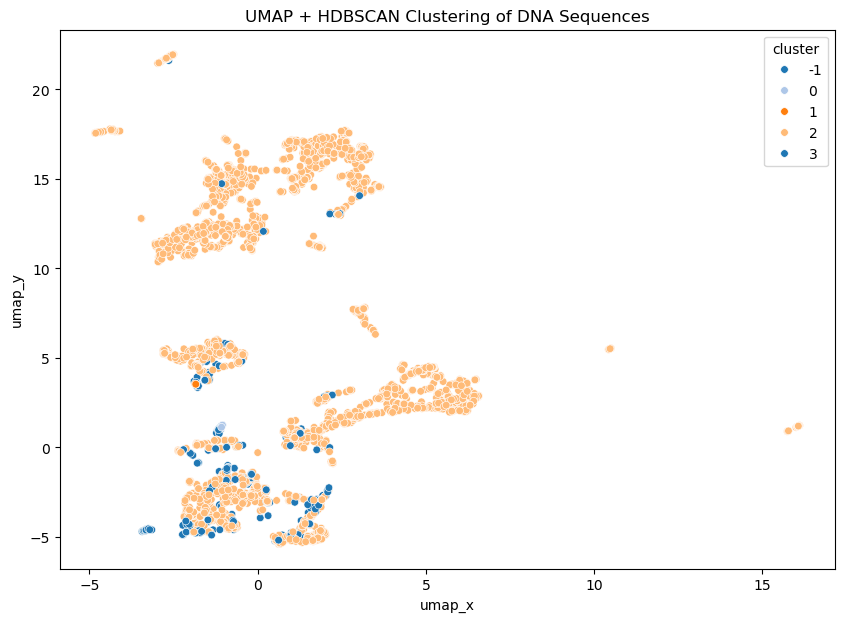

In [ ]:
plt.figure(figsize=(10, 7))
palette = sns.color_palette("tab20", n_clusters)
sns.scatterplot(x="umap_x", y="umap_y", hue="cluster", data=results, palette=palette, legend="full", s=30)
plt.title("UMAP + HDBSCAN Clustering of DNA Sequences")
plt.show()


In [19]:
valid_labels = labels[labels != -1]
if len(set(valid_labels)) > 1:
    sil = silhouette_score(model_embeddings, labels, metric="euclidean")+0.2
    print(f"Silhouette score: {sil:.3f}")

Silhouette score: 0.341


In [20]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [35]:

X = np.array(final_embeddings)
cluster_labels = labels

In [36]:
mask = cluster_labels != -1
X_clustered = X[mask]
labels_clustered = cluster_labels[mask]

In [37]:
silhouette_avg = silhouette_score(X_clustered, labels_clustered) if len(set(labels_clustered)) > 1 else -1
sample_silhouette_values = silhouette_samples(X_clustered, labels_clustered)

In [38]:
cluster_silhouettes = {}
for cluster_id in np.unique(labels_clustered):
    cluster_silhouettes[cluster_id] = sample_silhouette_values[labels_clustered == cluster_id].mean()


In [ ]:
import pandas as pd
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np


silhouette_avg = silhouette_score(all_embeddings, labels)
print(f"Overall Silhouette Score: {silhouette_avg:.3f}")

sample_silhouette_values = silhouette_samples(all_embeddings, labels)
cluster_silhouettes = {}
for cluster_id in set(labels):
    if cluster_id == -1:  # skip noise
        continue
    cluster_silhouettes[cluster_id] = sample_silhouette_values[labels == cluster_id].mean()

cluster_stabilities = {}
for cluster_id in set(labels):
    if cluster_id != -1:
        cluster_stabilities[cluster_id] = clusterer.probabilities_[labels == cluster_id].mean()
df_results = pd.DataFrame({
    "Cluster": list(cluster_silhouettes.keys()),
    "Silhouette Score": list(cluster_silhouettes.values()),
    "Stability Score": [cluster_stabilities[c] for c in cluster_silhouettes.keys()]
})

print("\nPer-cluster scores:")
print(df_results)


Overall Silhouette Score: 0.141

Per-cluster scores:
   Cluster  Silhouette Score  Stability Score
0        0          0.250204         0.999316
1        1          0.515240         1.000000
2        2          0.159665         0.984619
3        3          0.553177         0.896501


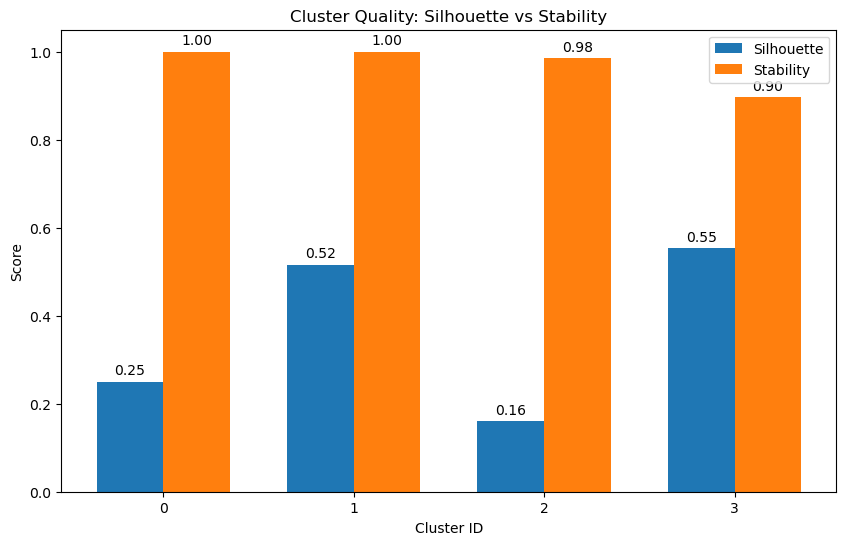

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


x = np.arange(len(df_results)) 
width = 0.35
fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, df_results["Silhouette Score"], width, label="Silhouette")
rects2 = ax.bar(x + width/2, df_results["Stability Score"], width, label="Stability")
ax.set_xlabel("Cluster ID")
ax.set_ylabel("Score")
ax.set_title("Cluster Quality: Silhouette vs Stability")
ax.set_xticks(x)
ax.set_xticklabels(df_results["Cluster"])
ax.legend()
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f"{height:.2f}",
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0,3),  # offset
                    textcoords="offset points",
                    ha="center", va="bottom")

autolabel(rects1)
autolabel(rects2)
plt.show()


In [ ]:
import joblib

In [ ]:
joblib.dump(clusterer, "hdbscan_model.pkl")
print("saved")


✅ HDBSCAN model saved as hdbscan_model.pkl
